In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch
from torch.utils.data import DataLoader
import sys 
sys.path.append('/Users/timostroschein/Desktop/Deep Learning/DLSC')
from Common import NeuralNet, MultiVariatePoly
# from drive.MyDrive.DLSC.Common import NeuralNet, MultiVariatePoly
import time
torch.autograd.set_detect_anomaly(True)
torch.manual_seed(128)
import pandas as pd

dev = 'cpu' # or  'cuda'

device =torch.device(dev)
torch.set_default_device(dev)

In [5]:
from google.colab import files
uploaded = files.upload()

Saving DataSolution.txt to DataSolution.txt


In [10]:
#read data
df = pd.read_csv('DataSolution.txt')
input_meas = torch.tensor(df[['t', 'x']].values, dtype=torch.float)
output_meas = torch.tensor(df[['tf']].values, dtype=torch.float)

#set constants
alpha_f = 0.005; h_f =5; Thot = 4; T0 = 1;  Tcold =1

#set hyperparams 
Lambda = 50; Hidden_layers=8; Neurons=100; 

#Training optimizer
Adam_opt = False; n_epochs_A = 5000
LBFGS_opt = True; n_epochs_L = 2

In [11]:

class Pinns:
    def __init__(self, n_int_, n_sb_, n_tb_):
        self.n_int = n_int_
        self.n_sb = n_sb_
        self.n_tb = n_tb_

        self.Final_loss = None;
        # Extrema of the solution domain (t,x) in [0,0.1]x[-1,1]
        self.domain_extrema = torch.tensor([[0, 8],  # Time dimension
                                            [0, 1]])  # Space dimension

        # Number of space dimensions
        self.space_dimensions = 1

        # Parameter to balance role of data and PDE
        self.lambda_u = Lambda

        # F Dense NN to approximate the solution of the underlying heat equation
        self.approximate_solution = NeuralNet(input_dimension=self.domain_extrema.shape[0], output_dimension=2,
                                              n_hidden_layers=Hidden_layers,
                                              neurons=Neurons,
                                              regularization_param=0.,
                                              regularization_exp=2.,
                                              retrain_seed=42)
        
        # Generator of Sobol sequences
        self.soboleng = torch.quasirandom.SobolEngine(dimension=self.domain_extrema.shape[0])

        # Training sets S_sb, S_tb, S_int as torch dataloader
        self.training_set_sb, self.training_set_tb, self.training_set_int = self.assemble_datasets()

    ################################################################################################
    # Function to linearly transform a tensor whose value are between 0 and 1
    # to a tensor whose values are between the domain extrema
    def convert(self, tens):
        assert (tens.shape[1] == self.domain_extrema.shape[0])
        tens =tens.to(device)
        return tens * (self.domain_extrema[:, 1] - self.domain_extrema[:, 0]) + self.domain_extrema[:, 0]

    # Initial condition
    def initial_condition(self, batch_size):
        return torch.full((batch_size,1), T0)


    ################################################################################################
    # Function returning the input-output tensor required to assemble the training set S_tb corresponding to the temporal boundary
    def add_temporal_boundary_points(self):
        t0 = self.domain_extrema[0, 0]
        input_tb = self.convert(self.soboleng.draw(self.n_tb))
        input_tb[:, 0] = torch.full(input_tb[:, 0].shape, t0)
        output_tb = self.initial_condition(self.n_tb)

        return input_tb, output_tb
    
    # Use boolen tensors to implement spatial boundary conditions
    def sb_0(self,time, c):
        t = ( time%4 ).detach().clone()
        sb_0 = c* (t<1).float().clone().detach() 
        return sb_0.view(-1,1) 

    def sb_L(self,time,c):
        t = ( time %4 ).detach().clone()
        sb_L = c* (t<3).float().clone().detach() - c* (t<2).float().clone().detach()
        return sb_L.view(-1,1)
    
    # Function returning the input-output tensor required to assemble the training set S_sb corresponding to the spatial boundary
    def add_spatial_boundary_points(self):
        x0 = self.domain_extrema[1, 0]
        xL = self.domain_extrema[1, 1]

        input_sb = self.convert(self.soboleng.draw(self.n_sb).to(device))

        input_sb_0 = torch.clone(input_sb)
        input_sb_0[:, 1] = torch.full(input_sb_0[:, 1].shape, x0)

        input_sb_L = torch.clone(input_sb)
        input_sb_L[:, 1] = torch.full(input_sb_L[:, 1].shape, xL)
        
        
        output_sb_0 = self.sb_0(input_sb[:,0].view(-1,1),Thot).detach()
        output_sb_L = self.sb_L(input_sb[:,0].view(-1,1),Tcold).detach()
        
        return torch.cat([input_sb_0, input_sb_L], 0), torch.cat([output_sb_0, output_sb_L], 0)

    #  Function returning the input-output tensor required to assemble the training set S_int corresponding to the interior domain where the PDE is enforced
    def add_interior_points(self):
        input_int = self.convert(self.soboleng.draw(self.n_int)).to(device)
        output_int = torch.zeros((input_int.shape[0], 1))
        return input_int, output_int

    # Function returning the training sets S_sb, S_tb, S_int as dataloader
    def assemble_datasets(self):
        input_sb, output_sb = self.add_spatial_boundary_points()   # S_sb
        input_tb, output_tb = self.add_temporal_boundary_points()  # S_tb
        input_int, output_int = self.add_interior_points()         # S_int

        training_set_sb = DataLoader(torch.utils.data.TensorDataset(input_sb, output_sb), batch_size=2*self.space_dimensions*self.n_sb, shuffle=False)
        training_set_tb = DataLoader(torch.utils.data.TensorDataset(input_tb, output_tb), batch_size=self.n_tb, shuffle=False)
        training_set_int = DataLoader(torch.utils.data.TensorDataset(input_int, output_int), batch_size=self.n_int, shuffle=False)

        return training_set_sb, training_set_tb, training_set_int

    ################################################################################################
    # Function to compute the terms required in the definition of the TEMPORAL boundary residual
    def apply_initial_condition(self, input_tb):
        u_pred_tb = self.approximate_solution(input_tb)[:,0]
        return u_pred_tb.view(-1,1)

    # Function to compute the terms required in the definition of the SPATIAL boundary residual
    def apply_boundary_conditions(self, input_sb):
        l = int(input_sb.shape[0]/2) 
        # idea: work with boolean tensors and entry wise multiplication
        input_sb.requires_grad = True
        
        NN_output = self.approximate_solution(input_sb)  
        u_pred_sb = NN_output[:,0]

        grad_u= torch.autograd.grad(u_pred_sb.sum(), input_sb, create_graph=True)[0].to(device)
        grad_u_x = grad_u[:, 1].view(-1,1)

        l = int(input_sb.shape[0]/2)
        
        t_0 = input_sb[:l,0].view(-1,1)
        grad_u_x_0 = grad_u_x[:l].view(-1,1)
        u_0 = u_pred_sb[:l].view(-1,1)
        
        
        t_L = input_sb[l:,0].view(-1,1)
        grad_u_x_L = grad_u_x[l:].view(-1,1)
        u_L = u_pred_sb[l:].view(-1,1)
        
        bool_0 = self.sb_0(t_0,1).detach()
        bool_L = self.sb_L(t_L,1).detach()
        assert(bool_0.shape== grad_u_x_0.shape)
        
        boundary_0= bool_0 * u_0 + (1-bool_0 )*grad_u_x_0
        boundary_L = bool_L * u_L + (1-bool_L )* grad_u_x_L
        
        boundary_points = torch.cat([boundary_0.view(-1,1),boundary_L.view(-1,1)],0)
        
        return boundary_points

    # Implement velocity of fluid in different phases with boolean tensor
    def U(self,t):
        t = ( t%4 ).float().detach().clone()
        u = ( t<=1).float().detach().clone() + ( t<=2).float().detach().clone() - ( t<=3).float().detach().clone()
        return u.view(-1,1)

    # Function to compute the PDE residuals
    def compute_pde_residual(self, input_int):
        input_int.requires_grad = True
        NN_output= self.approximate_solution(input_int)
        u = NN_output[:,0]
        Ts = NN_output[:,1]
        
        grad_u= torch.autograd.grad(u.sum(), input_int, create_graph=True)[0]
        grad_u_x = grad_u[:, 1].view(-1,1)
        grad_u_t = grad_u[:, 0].view(-1,1)
        grad_u_xx= torch.autograd.grad( grad_u_x.sum(),input_int, create_graph=True)[0][:, 1].view(-1,1).to(device)
        
        U_ = self.U(input_int[:,0])
        assert(U_.shape == grad_u_t.shape)
        
        residual = grad_u_t + U_*grad_u_x - alpha_f*grad_u_xx + h_f *(u - Ts)
        
        return residual.reshape(-1, )

    # Function to compute the total loss (weighted sum of spatial boundary loss, temporal boundary loss and interior loss)
    def compute_loss(self, inp_train_sb, u_train_sb, inp_train_tb, u_train_tb, inp_train_int, verbose=True):
        u_pred_sb = self.apply_boundary_conditions(inp_train_sb)
        u_pred_tb = self.apply_initial_condition(inp_train_tb)
    
        u_pred_meas = self.approximate_solution(input_meas)[:,0].view(-1,1)
        
        assert (u_pred_sb.shape[1] == u_train_sb.shape[1])
        assert (u_pred_tb.shape[1] == u_train_tb.shape[1])
        assert (u_pred_meas.shape[1] == output_meas.shape[1])

        #print(torch.cat([inp_train_sb, u_train_sb,self.sb_0(inp_train_sb[:,0],1)],1))
        
        r_int = self.compute_pde_residual(inp_train_int)
        r_sb = u_train_sb - u_pred_sb
        r_tb = u_train_tb - u_pred_tb
        r_meas = output_meas - u_pred_meas

        loss_sb = torch.mean(abs(r_sb) ** 2)
        loss_tb = torch.mean(abs(r_tb) ** 2)
        loss_int = torch.mean(abs(r_int) ** 2)
        loss_meas = torch.mean(abs(r_meas) ** 2)       #additional loss term 

        loss_u = loss_sb + loss_tb  + loss_meas
        
        loss = torch.log10(self.lambda_u * loss_u  + loss_int)
        if verbose: print("Total loss: ", round(loss.item(), 4), "| PDE Loss: ", round(torch.log10(loss_int).item(), 4), "| Function Loss: ", round(torch.log10(loss_u).item(), 4))

        return loss

    ################################################################################################
    def fit(self, num_epochs, optimizer, verbose=True):
        history = list()

        # Loop over epochs
        for epoch in range(num_epochs):
            if verbose: print("################################ ", epoch, " ################################")

            for j, ((inp_train_sb, u_train_sb), (inp_train_tb, u_train_tb), (inp_train_int, u_train_int)) in enumerate(zip(self.training_set_sb, self.training_set_tb, self.training_set_int)):
                def closure():
                    optimizer.zero_grad()
                    loss = self.compute_loss(inp_train_sb, u_train_sb, inp_train_tb, u_train_tb, inp_train_int, verbose=verbose)
                    loss.backward()

                    history.append(loss.item())
                    return loss

                optimizer.step(closure=closure)

        self.Final_loss = round(history[-1],4)
        print('Final Loss: ', history[-1])

        return history

    ################################################################################################
    def plotting(self):


        inputs = self.soboleng.draw(500000)
        inputs = self.convert(inputs)

        output = self.approximate_solution(inputs)
        output= output.to("cpu")
        inputs = inputs.to("cpu")

        Tf = output[:,0].reshape(-1, )
        Ts = output[:,1].reshape(-1, )

        
        
        fig, axs = plt.subplots(1,2,figsize=(16, 8), dpi=150)
        im1 = axs[0].scatter(inputs[:, 0].detach(), inputs[:, 1].detach(), c=Tf.detach(), cmap="jet")
        axs[0].set_xlabel("t")
        axs[0].set_ylabel("x")
        plt.colorbar(im1, ax=axs[0])
        axs[0].grid(True, which="both", ls=":")
        axs[0].set_title("Approximate Tf solution ")

        im2 = axs[1].scatter(inputs[:, 0].detach(), inputs[:, 1].detach(), c=Ts.detach(), cmap="jet")
        axs[1].set_xlabel("t")
        axs[1].set_ylabel("x")
        plt.colorbar(im2, ax=axs[1])
        axs[1].grid(True, which="both", ls=":")
        axs[1].set_title("Approximate Ts solution ")

        plt.savefig(f'Task_2_Regularizer_{Lambda}_hlayers_{Hidden_layers}_N_{Neurons}_FL_{self.Final_loss}_Adam_{Adam_opt*n_epochs_A}_LBFGS_{LBFGS_opt*n_epochs_L}.jpg')
        files.download(f'Task_2_Regularizer_{Lambda}_hlayers_{Hidden_layers}_N_{Neurons}_FL_{self.Final_loss}_Adam_{Adam_opt*n_epochs_A}_LBFGS_{LBFGS_opt*n_epochs_L}.jpg')
        plt.show()



################################  0  ################################
Total loss:  2.9605 | PDE Loss:  2.1019 | Function Loss:  1.1968
Total loss:  2.9364 | PDE Loss:  2.0714 | Function Loss:  1.1737
Total loss:  2.9362 | PDE Loss:  2.0711 | Function Loss:  1.1735
Total loss:  2.8187 | PDE Loss:  1.9162 | Function Loss:  1.0616
Total loss:  2.6944 | PDE Loss:  2.1576 | Function Loss:  0.8463
Total loss:  2.3466 | PDE Loss:  1.6984 | Function Loss:  0.537
Total loss:  2.7371 | PDE Loss:  2.0563 | Function Loss:  0.9365
Total loss:  2.0664 | PDE Loss:  1.0371 | Function Loss:  0.3248
Total loss:  2.2489 | PDE Loss:  1.4445 | Function Loss:  0.4758
Total loss:  2.0204 | PDE Loss:  0.9262 | Function Loss:  0.285
Total loss:  1.9275 | PDE Loss:  0.9331 | Function Loss:  0.1822
Total loss:  1.7921 | PDE Loss:  0.949 | Function Loss:  0.0259
Total loss:  1.7701 | PDE Loss:  0.8484 | Function Loss:  0.0158
Total loss:  1.7519 | PDE Loss:  0.7868 | Function Loss:  0.0032
Total loss:  1.7316 | P

NameError: name 'files' is not defined

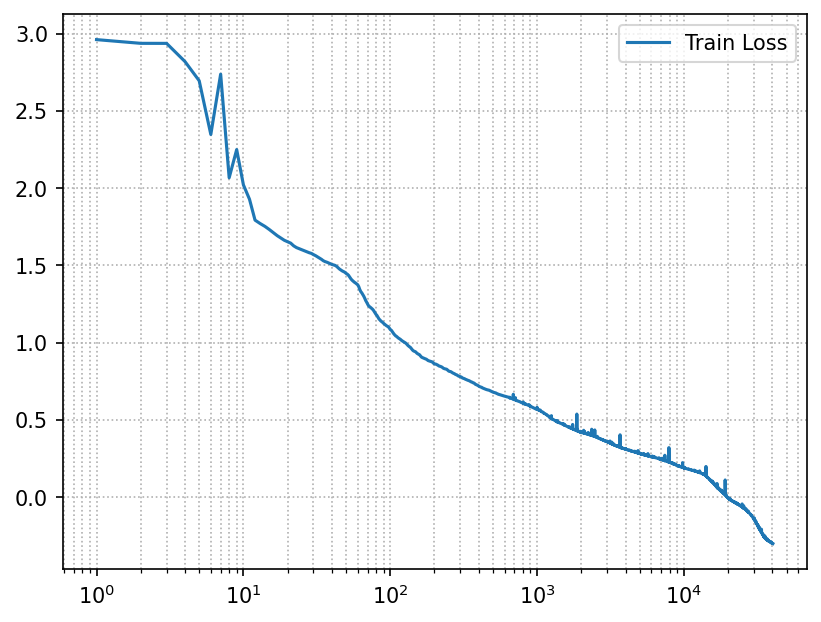

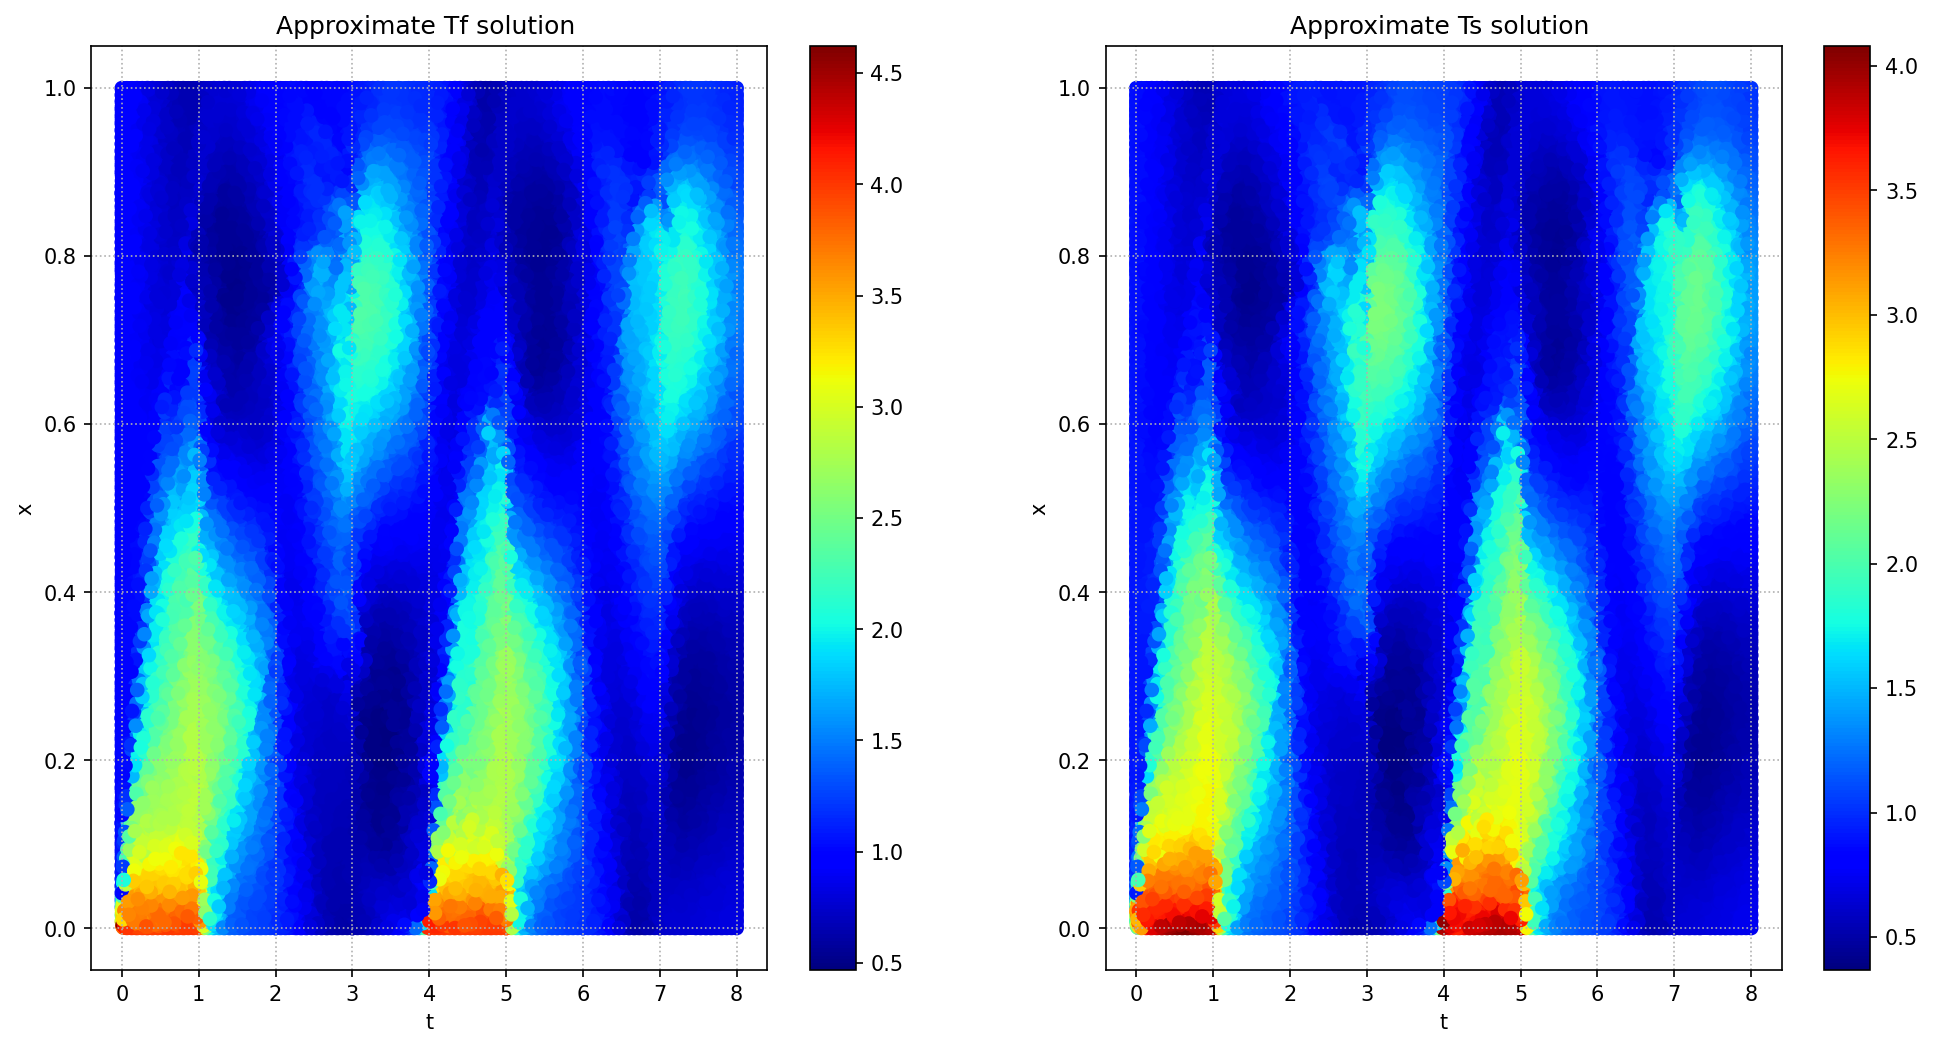

In [12]:

n_int = 256 * 4
n_sb = 64  * 4
n_tb = 64  



pinn = Pinns(n_int, n_sb, n_tb)


def plot_hist(hist):
    plt.figure(dpi=150)
    plt.grid(True, which="both", ls=":")
    plt.plot(np.arange(1, len(hist) + 1), hist, label="Train Loss")
    plt.xscale("log")
    plt.legend()


optimizer_LBFGS = optim.LBFGS(pinn.approximate_solution.parameters(),
                              lr=float(0.5),
                              max_iter=50000,
                              max_eval=50000,
                              history_size=150,
                              line_search_fn="strong_wolfe",
                              tolerance_change=1.0 * np.finfo(float).eps)
optimizer_ADAM = optim.Adam(pinn.approximate_solution.parameters(),
                            lr=float(0.001))


if Adam_opt:

    hist_A = pinn.fit(num_epochs=n_epochs_A,
                    optimizer=optimizer_ADAM,
                    verbose=True)
    plot_hist(hist_A)

if LBFGS_opt: 
    hist_L = pinn.fit(num_epochs=n_epochs_L,
                    optimizer=optimizer_LBFGS,
                    verbose=True)

    plot_hist(hist_L)

pinn.plotting()


In [ ]:

df = pd.read_csv('DataSolution.txt')
testing_points = torch.tensor(df[['t', 'x']].values, dtype=torch.float)

output_data= pinn.approximate_solution(testing_points).to('cpu')

output_f_np = output_f[:,0].detach().numpy()
output_s_np = output_s[:,1].detach().numpy()

test_df = pd.DataFrame({'t': testing_points[:,0],'x': testing_points[:,1],'ts': output_s_np})
df.to_csv(f'Task_2_Regularizer_{Lambda}_hlayers_{Hidden_layers}_N_{Neurons}_FL_{pinn.Final_loss}_Adam_{Adam_opt*n_epochs_A}_LBFGS_{LBFGS_opt*n_epochs_L}.txt',index=False) #save to file


NameError: ignored

In [ ]:
files.download(f'Task_2_Regularizer_{Lambda}_hlayers_{Hidden_layers}_N_{Neurons}_FL_{pinn.Final_loss}_Adam_{Adam_opt*n_epochs_A}_LBFGS_{LBFGS_opt*n_epochs_L}.txt')
